# Durable Consumption Model

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

# load the DurableConsumptionModel module
from TwoAssetModel import TwoAssetModelClass 

import numba as nb
nb.set_num_threads(8)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# NEGM - nested endogenous grid method

In [2]:
model_negm = TwoAssetModelClass(
    name='example_negm',
    par={
        'solmethod':'negm',
        'cross_compute':True, # whether to cross-compute MPC if discrete choice is altered
        'do_print':True
        })

model_negm.precompile_numba() # solve with very coarse grids
model_negm.solve()
model_negm.simulate()

numba precompiled in 17.6 secs
 t = 54 solved in 0.1 secs
 w computed in 7.5 secs
 solved keeper problem in 0.2 secs
 solved adjuster problem in 0.0 secs
 t = 53 solved in 7.8 secs
 w computed in 7.5 secs
 solved keeper problem in 0.2 secs
 solved adjuster problem in 0.0 secs
 t = 52 solved in 15.6 secs
 w computed in 7.5 secs
 solved keeper problem in 0.2 secs
 solved adjuster problem in 0.0 secs
 t = 51 solved in 23.3 secs
 w computed in 7.5 secs
 solved keeper problem in 0.2 secs
 solved adjuster problem in 0.0 secs
 t = 50 solved in 31.1 secs
 w computed in 7.5 secs
 solved keeper problem in 0.2 secs
 solved adjuster problem in 0.0 secs
 t = 49 solved in 38.8 secs
 w computed in 7.5 secs
 solved keeper problem in 0.2 secs
 solved adjuster problem in 0.0 secs
 t = 48 solved in 46.6 secs
 w computed in 7.5 secs
 solved keeper problem in 0.2 secs
 solved adjuster problem in 0.0 secs
 t = 47 solved in 54.3 secs
 w computed in 7.6 secs
 solved keeper problem in 0.2 secs
 solved adjuster

## Plot

#### Life-cycle profiles (Figure 2)

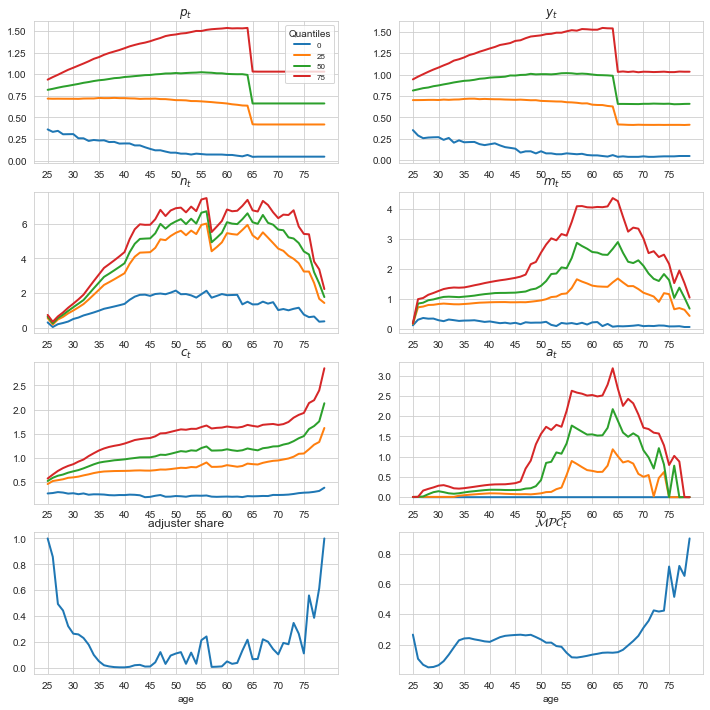

In [3]:
model_negm.lifecycle(quantiles=True)

#### Life cycle MPC (Figure 3b)

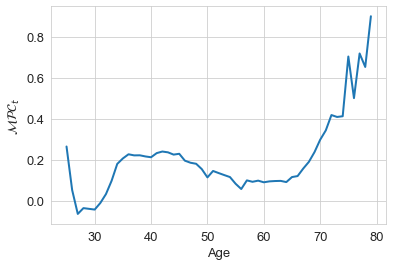

<Figure size 432x288 with 0 Axes>

In [4]:
# x-axis labels
age = np.arange(model_negm.par.T)+model_negm.par.Tmin

plt.plot(age,np.mean(model_negm.sim.mpc,axis=1),lw=2)

#setting labels and fontsize
plt.xlabel('Age',fontsize=13)
plt.ylabel('$\mathcal{MPC}_{t}$',fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.show()

plt.savefig('output/mpc_lifecycle_twoasset.png')

#### MPC over cash-on-hand (Figure 4b)

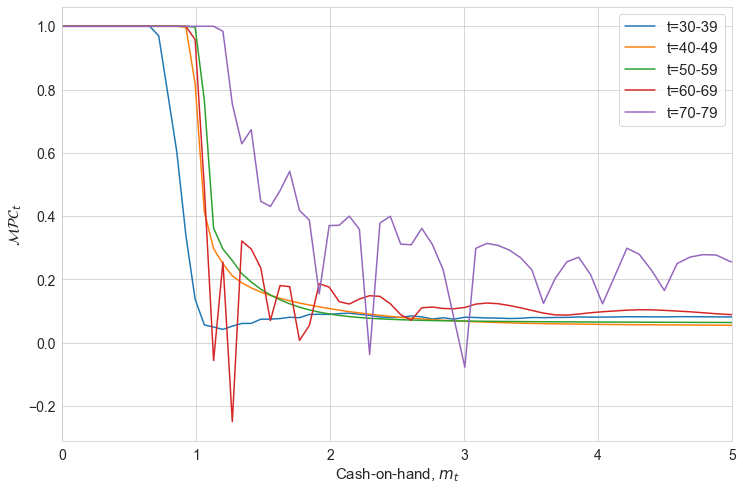

In [5]:
model_negm.mpc_over_cash_on_hand()

## Computing MPCs (Table 3)

In [6]:
mean_mpc = np.mean(model_negm.sim.mpc)*100
mean_mpc_working = np.mean(model_negm.sim.mpc[:model_negm.par.Tr-1,:])*100
mean_mpc_retirement = np.mean(model_negm.sim.mpc[model_negm.par.Tr:,:])*100

print(f'Mean annual MPC is {mean_mpc:.2f} pct.')
print(f'Mean annual MPC during work life is {mean_mpc_working:.2f} pct.')
print(f'Mean annual MPC during retirement is {mean_mpc_retirement:.2f} pct.')

Mean annual MPC is 20.69 pct.
Mean annual MPC during work life is 13.08 pct.
Mean annual MPC during retirement is 41.24 pct.


## Sensitivity check - interest rate spread

In [7]:
# allocate candidate values
Rs = [1.01, 1.01, 1.01, 1.02, 1.02, 1.02, 1.03, 1.03, 1.03,]
spreads = [0.04, 0.05, 0.06, 0.04, 0.05, 0.06, 0.04, 0.05, 0.06]
MPCs = np.nan + np.zeros(shape=(len(Rs),3))
i = 0 # set counter

for R,spread in zip(Rs,spreads):
    # solve
    model = TwoAssetModelClass(
        name='example_negm',
        par={
            'solmethod':'negm',
            'R': R,
            'Rh':R+spread,    
            'do_print':False})
    model.precompile_numba() # solve with very coarse grids
    model.solve()
    model.simulate()

    # compute MPCs
    MPCs[i,0] = np.mean(model.sim.mpc)*100
    MPCs[i,1] = np.mean(model.sim.mpc[:model.par.Tr-1,:])*100
    MPCs[i,2] = np.mean(model.sim.mpc[model.par.Tr:,:])*100

    # print
    print(f"For (R={R:.2f}, Rh={R+spread:.2f}, spread={spread:.2f}):")
    print(f'Mean annual MPC is {MPCs[i,0]:.2f} pct.')
    print(f'Mean annual MPC during work life is {MPCs[i,1]:.2f} pct.')
    print(f'Mean annual MPC during retirement is {MPCs[i,2]:.2f} pct.')

    i += 1 # update counter

For (R=1.01, Rh=1.05, spread=0.04):
Mean annual MPC is 20.00 pct.
Mean annual MPC during work life is 12.42 pct.
Mean annual MPC during retirement is 40.37 pct.
For (R=1.01, Rh=1.06, spread=0.05):
Mean annual MPC is 23.33 pct.
Mean annual MPC during work life is 16.49 pct.
Mean annual MPC during retirement is 41.98 pct.
For (R=1.01, Rh=1.07, spread=0.06):
Mean annual MPC is 26.47 pct.
Mean annual MPC during work life is 19.43 pct.
Mean annual MPC during retirement is 45.82 pct.
For (R=1.02, Rh=1.06, spread=0.04):
Mean annual MPC is 20.34 pct.
Mean annual MPC during work life is 12.40 pct.
Mean annual MPC during retirement is 41.63 pct.
For (R=1.02, Rh=1.07, spread=0.05):
Mean annual MPC is 22.65 pct.
Mean annual MPC during work life is 15.63 pct.
Mean annual MPC during retirement is 41.63 pct.
For (R=1.02, Rh=1.08, spread=0.06):
Mean annual MPC is 23.78 pct.
Mean annual MPC during work life is 15.83 pct.
Mean annual MPC during retirement is 45.27 pct.
For (R=1.03, Rh=1.07, spread=0.04)

# NVFI - nested value function iteration

In [4]:
model_nvfi = TwoAssetModelClass(name='example_nvfi',par={'solmethod':'nvfi','do_print':True})
model_nvfi.precompile_numba() # solve with very coarse grids
model_nvfi.solve()
model_nvfi.simulate()

numba precompiled in 16.5 secs
 t = 54 solved in 0.1 secs
 w computed in 4.9 secs
 solved keeper problem in 3.4 secs
 solved adjuster problem in 0.0 secs
 t = 53 solved in 8.4 secs
 w computed in 4.6 secs
 solved keeper problem in 3.3 secs
 solved adjuster problem in 0.0 secs
 t = 52 solved in 16.4 secs
 w computed in 4.6 secs
 solved keeper problem in 3.4 secs
 solved adjuster problem in 0.0 secs
 t = 51 solved in 24.4 secs
 w computed in 4.6 secs
 solved keeper problem in 3.4 secs
 solved adjuster problem in 0.0 secs
 t = 50 solved in 32.3 secs
 w computed in 4.6 secs
 solved keeper problem in 3.4 secs
 solved adjuster problem in 0.0 secs
 t = 49 solved in 40.4 secs
 w computed in 4.6 secs
 solved keeper problem in 3.4 secs
 solved adjuster problem in 0.0 secs
 t = 48 solved in 48.4 secs
 w computed in 4.6 secs
 solved keeper problem in 3.4 secs
 solved adjuster problem in 0.0 secs
 t = 47 solved in 56.4 secs
 w computed in 4.6 secs
 solved keeper problem in 3.4 secs
 solved adjuster

# VFI
Please note that this will probably run for more than 13hr....

In [14]:
model_vfi = TwoAssetModelClass(name='example_vfi',par={'solmethod':'vfi','do_print':True})
model_vfi.precompile_numba() # solve with very coarse grids
model_vfi.solve()
model_vfi.simulate()
model_vfi.save()

numba precompiled in 31.2 secs
 t = 54 solved in 0.1 secs
 w computed in 7.5 secs
 solved keeper problem in 879.3 secs
 solved adjuster problem in 29.3 secs
 t = 53 solved in 916.2 secs
 w computed in 7.5 secs
 solved keeper problem in 873.4 secs
 solved adjuster problem in 21.2 secs
 t = 52 solved in 1818.3 secs
 w computed in 7.4 secs
 solved keeper problem in 3624.4 secs
 solved adjuster problem in 22.3 secs
 t = 51 solved in 5472.5 secs
 w computed in 7.4 secs
 solved keeper problem in 875.3 secs
 solved adjuster problem in 22.1 secs
 t = 50 solved in 6377.3 secs
 w computed in 7.6 secs
